# Data Engineering
Also see Chapter 8

In [14]:
# Global imports and settings
from preamble import *
%matplotlib inline
#%load_ext autoreload
%autoreload 2
plt.rcParams['savefig.dpi'] = 120 # Use 300 for PDF, 100 for slides
#InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

Successful data mining involves far more than selecting a learning algorithm and running it over your data
* Hyperparameter tuning is often crucial
* For some algorithms, you can also get significantly better results by transforming the data beforehand
    
Many algorithms make assumptions about data:
* Naive Bayes: features are conditionally independent
* kNN: all features are equally relevant
* SVMs and Neural nets assume that features are similarly scaled
* Most regression algorithms assume that the data is not too noisy
* Some algorithms will only work on purely numeric/categorical data

We can engineer the data beforehand to match these assumptions

Note: WEKA is very good at 'hiding' these issues by tackling them internally in the algorithms, but:
* this is not always the case and we sometimes need to engineer data manually
* it is important to realize that/how this happens to interpret the results (and use other toolboxes)

### Types of data transformations:
* __Scaling__: make sure that all (numeric) feature values are distributed equally
* __Discretization__: transform numeric features to categorical ones
* __Attribute (feature) selection__: select only the most important attributes
* __Projections (dimensionality reduction)__: replace all features with a smaller set of new _synthetic_ features that retain most of the information

Also:
* __Outlier (anomaly) detection__: detect and remove samples that are noisy/wrong
* __Output encoding__: transform multi-class outputs to binary ones
* __Calibrate probabilities__: transform model predictions so that they can be interpreted as probabilities

## Scaling
* One of the simplest forms of data engineering
* Still many different variants.
* See WEKA Filters (Unsupervised > Attribute)
    * `Normalize`: brings all values in [0,1] (or any min,max)
    * `Standardize`: values have mean 0, standard deviation 1
        * More robust: remove outliers first, then standardize features
* In some algorithms, e.g. SVMs (`SMO`), the scaling happens internally
    * Can still be controled by a hyperparameter

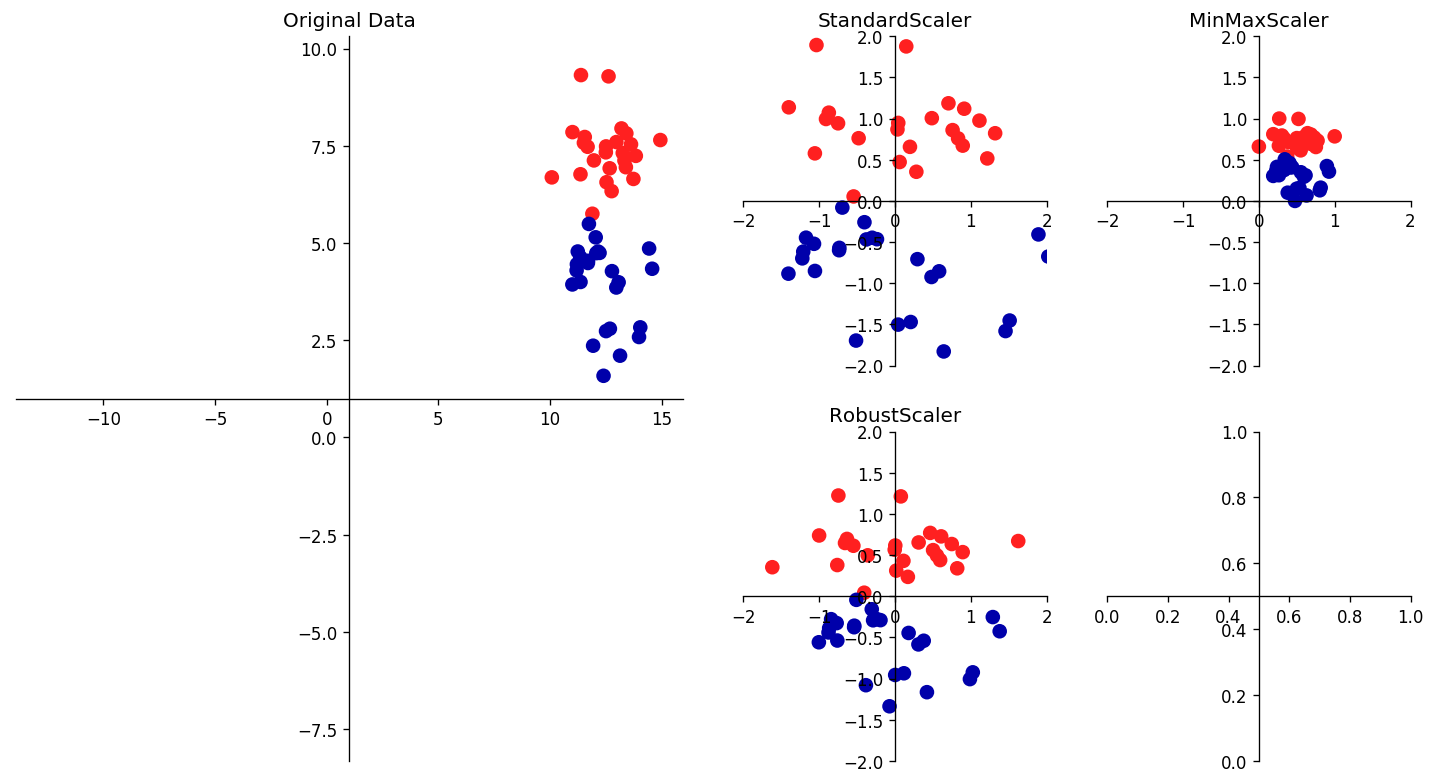

In [15]:
mglearn.plots.plot_scaling()

* With _any_ preprocessing technique, it is important to run it on the training data _only_
    * E.g. scaling: take the min/max values only from the training data 
* To make predictions, you should apply the _same_ preprocessing to the test data
    * For scaling: scale the test data with the min/max values learned from training data
* Can become tricky with cross-validation procedures
    * Use `FilteredClassifier` to tie the preprocessing and learner together

![FC](./images/10_weka_filteredclassifier.png)

What happens if you don't scaling training and test data the same way?

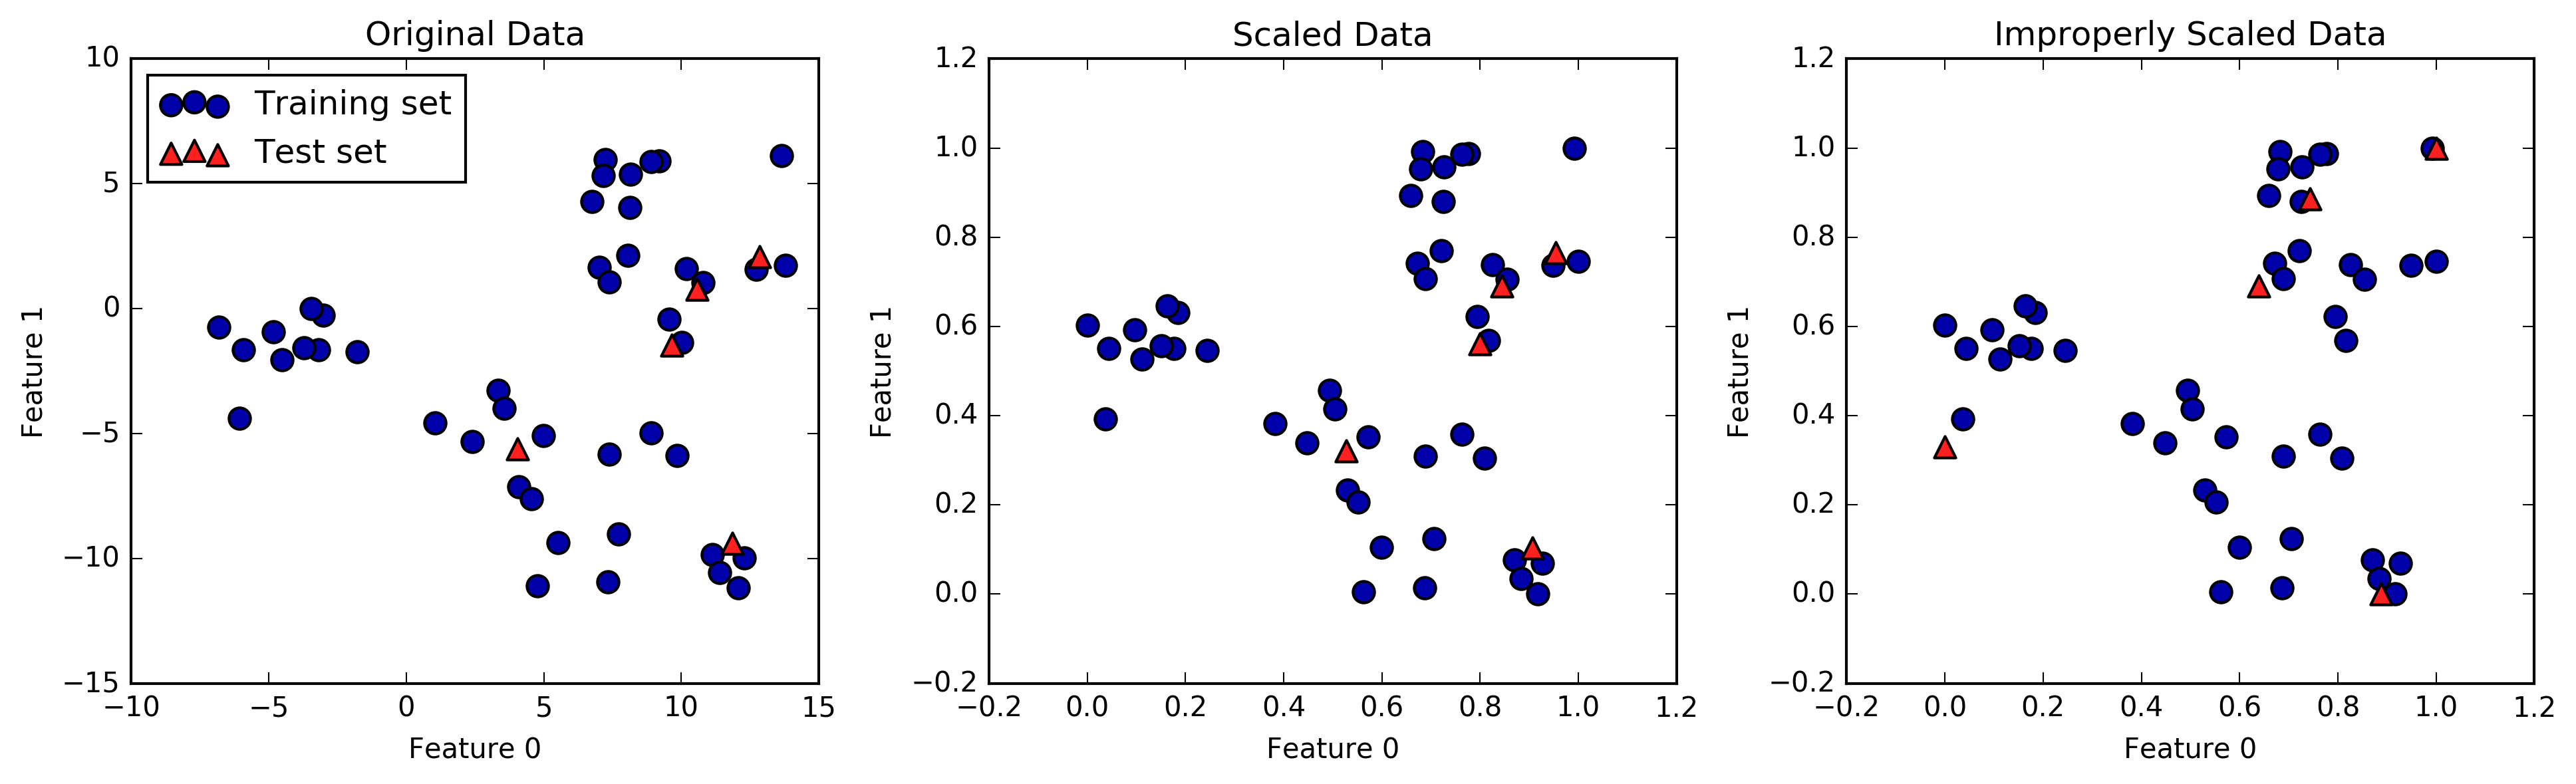

In [8]:
from sklearn.datasets import make_blobs
# make synthetic data
X, _ = make_blobs(n_samples=50, centers=5, random_state=4, cluster_std=2)
# split it into training and test set
X_train, X_test = train_test_split(X, random_state=5, test_size=.1)

# plot the training and test set
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
axes[0].scatter(X_train[:, 0], X_train[:, 1],
                c=mglearn.cm2(0), label="Training set", s=60)
axes[0].scatter(X_test[:, 0], X_test[:, 1], marker='^',
                c=mglearn.cm2(1), label="Test set", s=60)
axes[0].legend(loc='upper left')
axes[0].set_title("Original Data")

# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# visualize the properly scaled data
axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c=mglearn.cm2(0), label="Training set", s=60)
axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], marker='^',
                c=mglearn.cm2(1), label="Test set", s=60)
axes[1].set_title("Scaled Data")

# rescale the test set separately
# so that test set min is 0 and test set max is 1
# DO NOT DO THIS! For illustration purposes only
test_scaler = MinMaxScaler()
test_scaler.fit(X_test)
X_test_scaled_badly = test_scaler.transform(X_test)

# visualize wrongly scaled data
axes[2].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c=mglearn.cm2(0), label="training set", s=60)
axes[2].scatter(X_test_scaled_badly[:, 0], X_test_scaled_badly[:, 1],
                marker='^', c=mglearn.cm2(1), label="test set", s=60)
axes[2].set_title("Improperly Scaled Data")

for ax in axes:
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
fig.tight_layout()

## Discretization
* Transform a numeric feature into one or more categorical ones
    * Transform into one k-valued discretized attribute
    * Replace with k–1 new binary attributes 
        * values a,b,c: a→{0,0}, b→{1,0}, c→{1,1} or a→{0,0,1}, b→{0,1,0}, c→{1,0,0}
* Some algorithms can only handle discrete features (e.g. OneR)
    * In weka, these algorithms often do discretization internally
* Some learners can handle numeric values, but are:
    * Naive (Naïve Bayes assumes normal distribution)
    * Slow (1R sorts instances before discretization)
    * Local (C4.5 discretizes in nodes, on less and less data)
 Discretization:


    
* Discretized features can be encoded as new features that help modelling (see later)

### Equal-interval binning
* Create intervals of fixed width
* Often creates bins with many or very few examples
![equal interval](./images/10_binning1.png)

### Equal-frequency binning
* Create bins of equal size
* Also called histogram equalization
* Variant: Proportional k-interval discretization
    * equal-frequency binning with number of bins = sqrt(dataset size)
![equal interval](./images/10_binning2.png)

* In WEKA, see Filters > Unsupervised > Attribute > Discretize
* Options:
    * Which attributes to discretize
    * Number of bins
    * Use equal frequency binning
    * Make binary: encode as $k-1$ binary features rather than 1 $k$-valued feature
    * FindNumBins: optimize number of bins using leave-one-out cross-validation

![Discretize](./images/10_weka_discretize.png)

* In some models, e.g. linear models and decision trees, you can get better performance by having additional features
* Example: decision tree and linear regression
    * create bins and add each bin as a new 0/1 feature

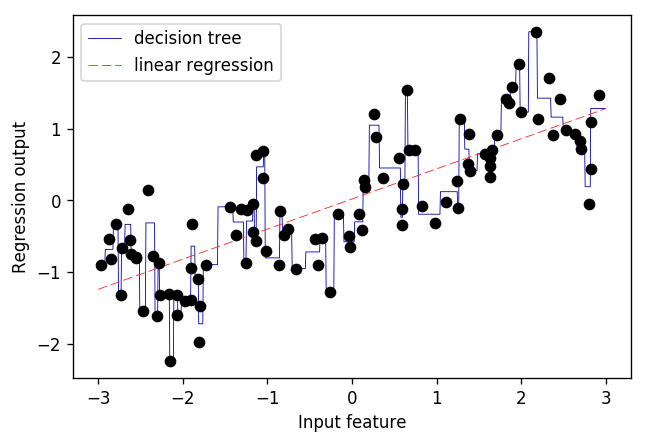

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_split=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

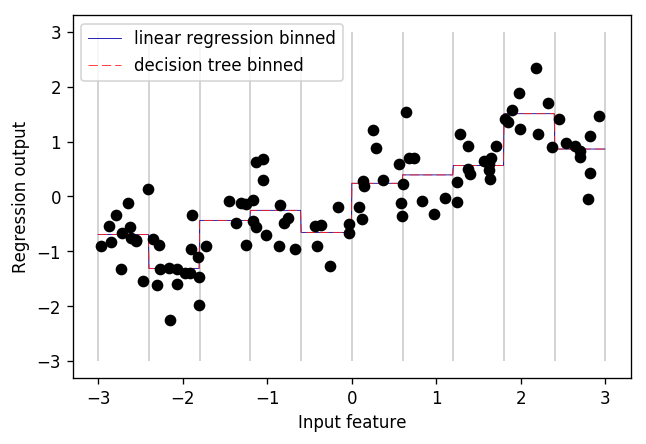

In [18]:
from sklearn.preprocessing import OneHotEncoder

bins = np.linspace(-3, 3, 11)
which_bin = np.digitize(X, bins=bins)

# transform using the OneHotEncoder.
encoder = OneHotEncoder(sparse=False)
# encoder.fit finds the unique values that appear in which_bin
encoder.fit(which_bin)
# transform creates the one-hot encoding
X_binned = encoder.transform(which_bin)

line_binned = encoder.transform(np.digitize(line, bins=bins))

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(bins, -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

### Supervised Discretization
* Discretize using information from the target attribute
* Entropy-based discretization: seek discretization that makes bins as pure as possible
    * Very similar to how decision trees work
    * Sort values, place thresholds between values where class change occurs
    * Use the thresholds whose cut would reduce entropy most

* Compute information content for every possible split -> line A
* Split on lowest value
* Repeat

![SuperDisc](./images/10_supervised_discretization2.png)

## Attribute selection
Irrelevant attributes can 'confuse' algorithms. Some examples?

* kNN: distance between neighbors increases with every new dimension (attribute)
    * Curse of dimensionality: to maintain the same 'density' of samples, for every new attribute you also need to add exponentially more samples
* Decision trees: data fragmentation
    * The deeper down the tree, the fewer samples remain
    * As some point, even a random attribute will separate the remaining data _purely by chance_
* Naive Bayes: sensitive to _redundant_ attributes
    * If one feature is explained by other attribute, it is clearly not independent
        * Predicted probablities may be way off
    * Robust against _irrelevant_ attributes
        * These are typically independent of others, can be learned to ignore

* To avoid these problems, we can select features beforehand
* Other benefits:
    * Models are trained faster (fewer attributes to consider)
    * Fewer features: better interpretability
        
* Two main methods:
    * Filters: features are removed beforehand, independenly from the learner
    * Wrapper: build multiple models with different sets of features and see which perform best
        * Learner is wrapper in attribute selection algorithm

### Filter methods
* Two types of filter methods:
    * Feature selection methods: find an optimal feature subset
    * Feature ranking methods: rank features by importance, but doesn't provide a threshold
        * You have to choose the threshold yourself (e.g. keep 50% of all features)
* Simple technique: find smallest feature set that separates classes
    * Requires to try all combinations of features
    * Will keep noisy features, causes overfitting

#### Correlation-based feature selection
* Select features that:
    * correlate well with the target feature
    * correlate little with other features
* see WEKA Filters > Supervised > Attribute > AttributeSelection
* Different ways to measure this:
    * `CorrelationAttributeEval`: uses Pierson's Corrrelation Coefficient $\rho$
    ![Pierson](./images/10_Pierson.png)
    * `CfsSubsetEval`: Correlation-based Feature Subset Selection
        * Measure correlation between 2 features by _symmetric uncertainty_:
        $$ U(A,B) = 2 \frac{H(A), H(B)-H(A,B)}{H(A)+H(B)}$$
            * H is entropy, H(A,B) is joint entropy, measured on all combinations of values of A and B
        * Select the set of features $A_j$ which maximizes:
        $$ \frac{\sum_{j} U(A_j,B)}{\sqrt{\sum_{i} \sum_{j} U(A_i,A_j)}}$$
            * C is the class attribute
        * Default in WEKA

#### Model-based methods
* Train a model and deduce from the model which features are important
* Select most important feature, remove, repeat
    * Produces ranking of features 
* Which learning algorithms learn feature importances?

* C4.5 (decision trees): Look at top-level node
    * `InfoGainAttributeEval`: choose features that most reduce entropy of the class distribution
* kNN: Take random samples and sees if a specific feature seperates them from their nearest neighbor of a different class
    * `ReliefF`
        ![Relief](./images/10_relieff.png)
* Linear models: select the features with the greatest corresponding weights
    $$\hat{y} = w_0 + w_1 * x_1 + ... + w_p * x_p$$


### Wrapper methods
* Try all combinations of features, build your model, evaluate with cross-validation
* Remove features that, when added, decrease CV performance
* Optimal, but expensive!
![FS](./images/10_forward_selection.png)

* Speed up the search:
    * Greedy search: $O(k^2)$ for $k$ attributes
    * Forward selection: select single best features, add it, repeat
    * Backward selection: select single worst features, renove it, repeat
    * Bidirectional search: Do both forward and backward selection, meet in the middle
    * Racing: 
        * Evaluate feature sets on very small sample
        * Remember the ones that work best, evaluate them on a larger sample, etc.

* see WEKA Filters > Supervised > Attribute > AttributeSelection 
* Select `Evaluator`: `WrapperSubsetEval` and select your algorithms
* Choose your search algorithm (e.g. greedy or BestFirst)

WEKA Filters
![FS1](./images/10_weka_fs1.png)

WEKA Attribute Selection tab
![FS1](./images/10_weka_fs2.png)

## Dimensionality Reduction
* Main techniques:
    * Principal Component Analysis (PCA)
    * Random Projections

### Principal Component Analysis (PCA)

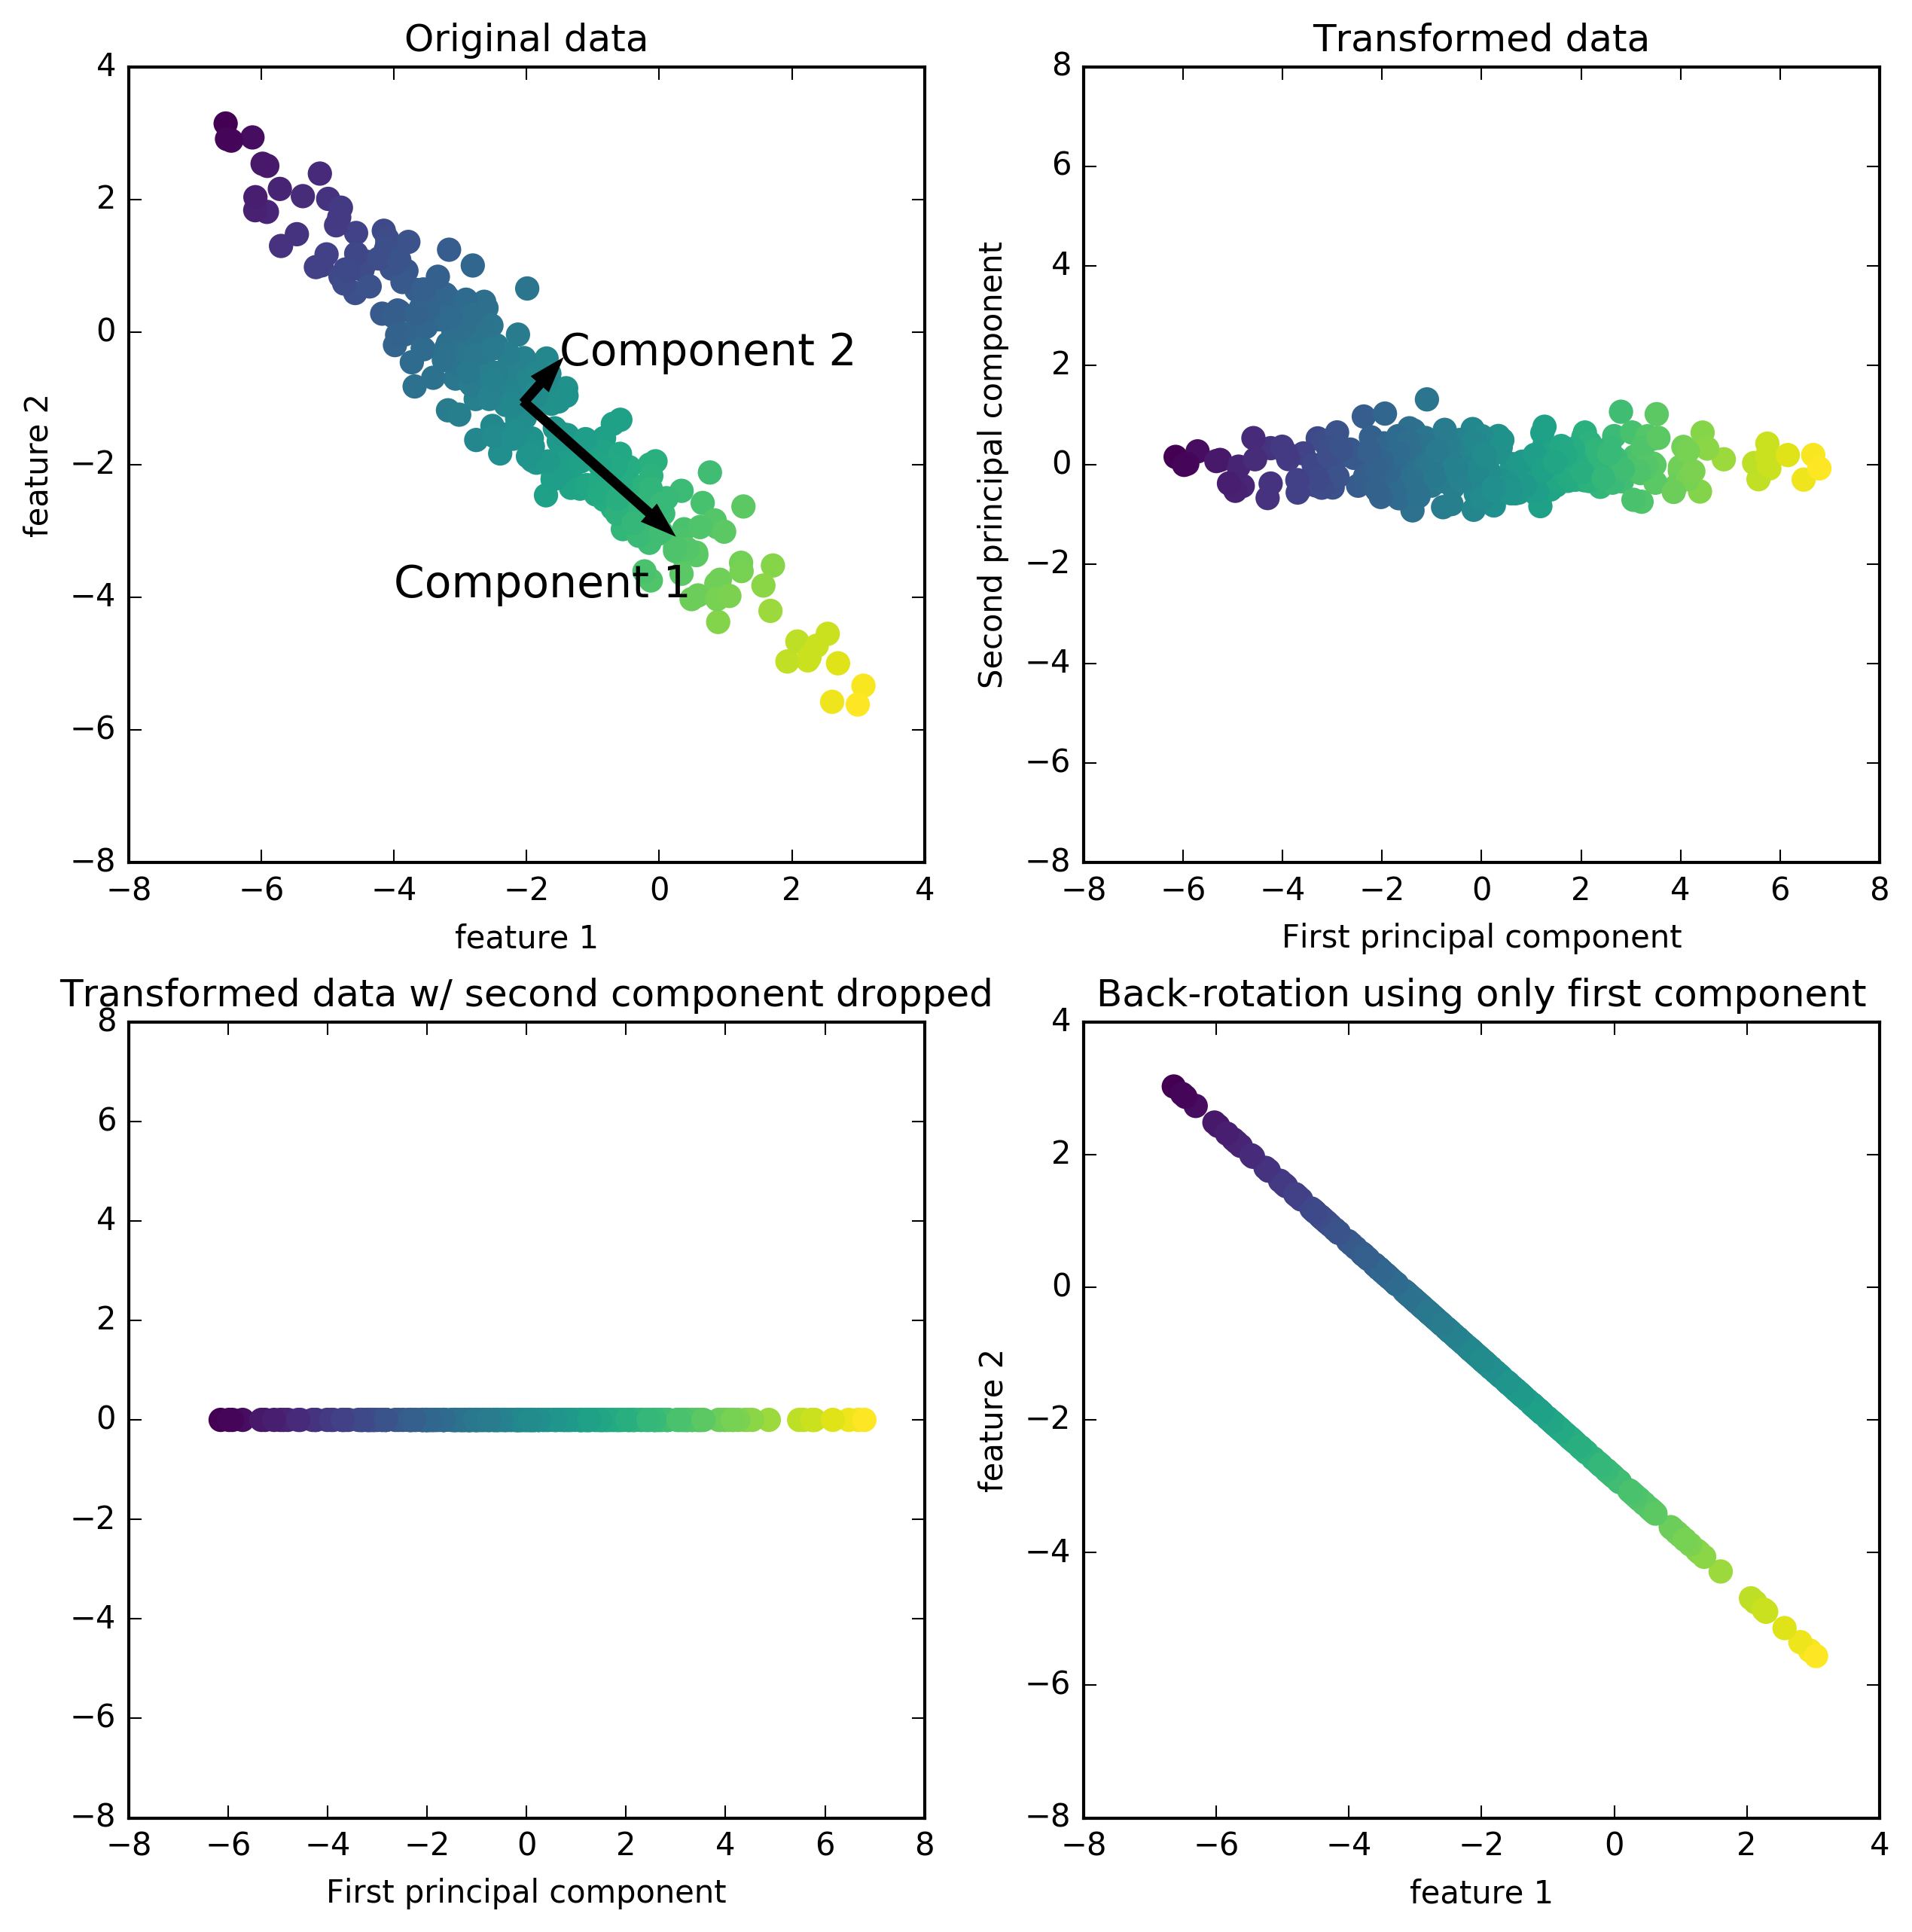

In [13]:
mglearn.plots.plot_pca_illustration()

##### Applying PCA to the cancer dataset for visualization

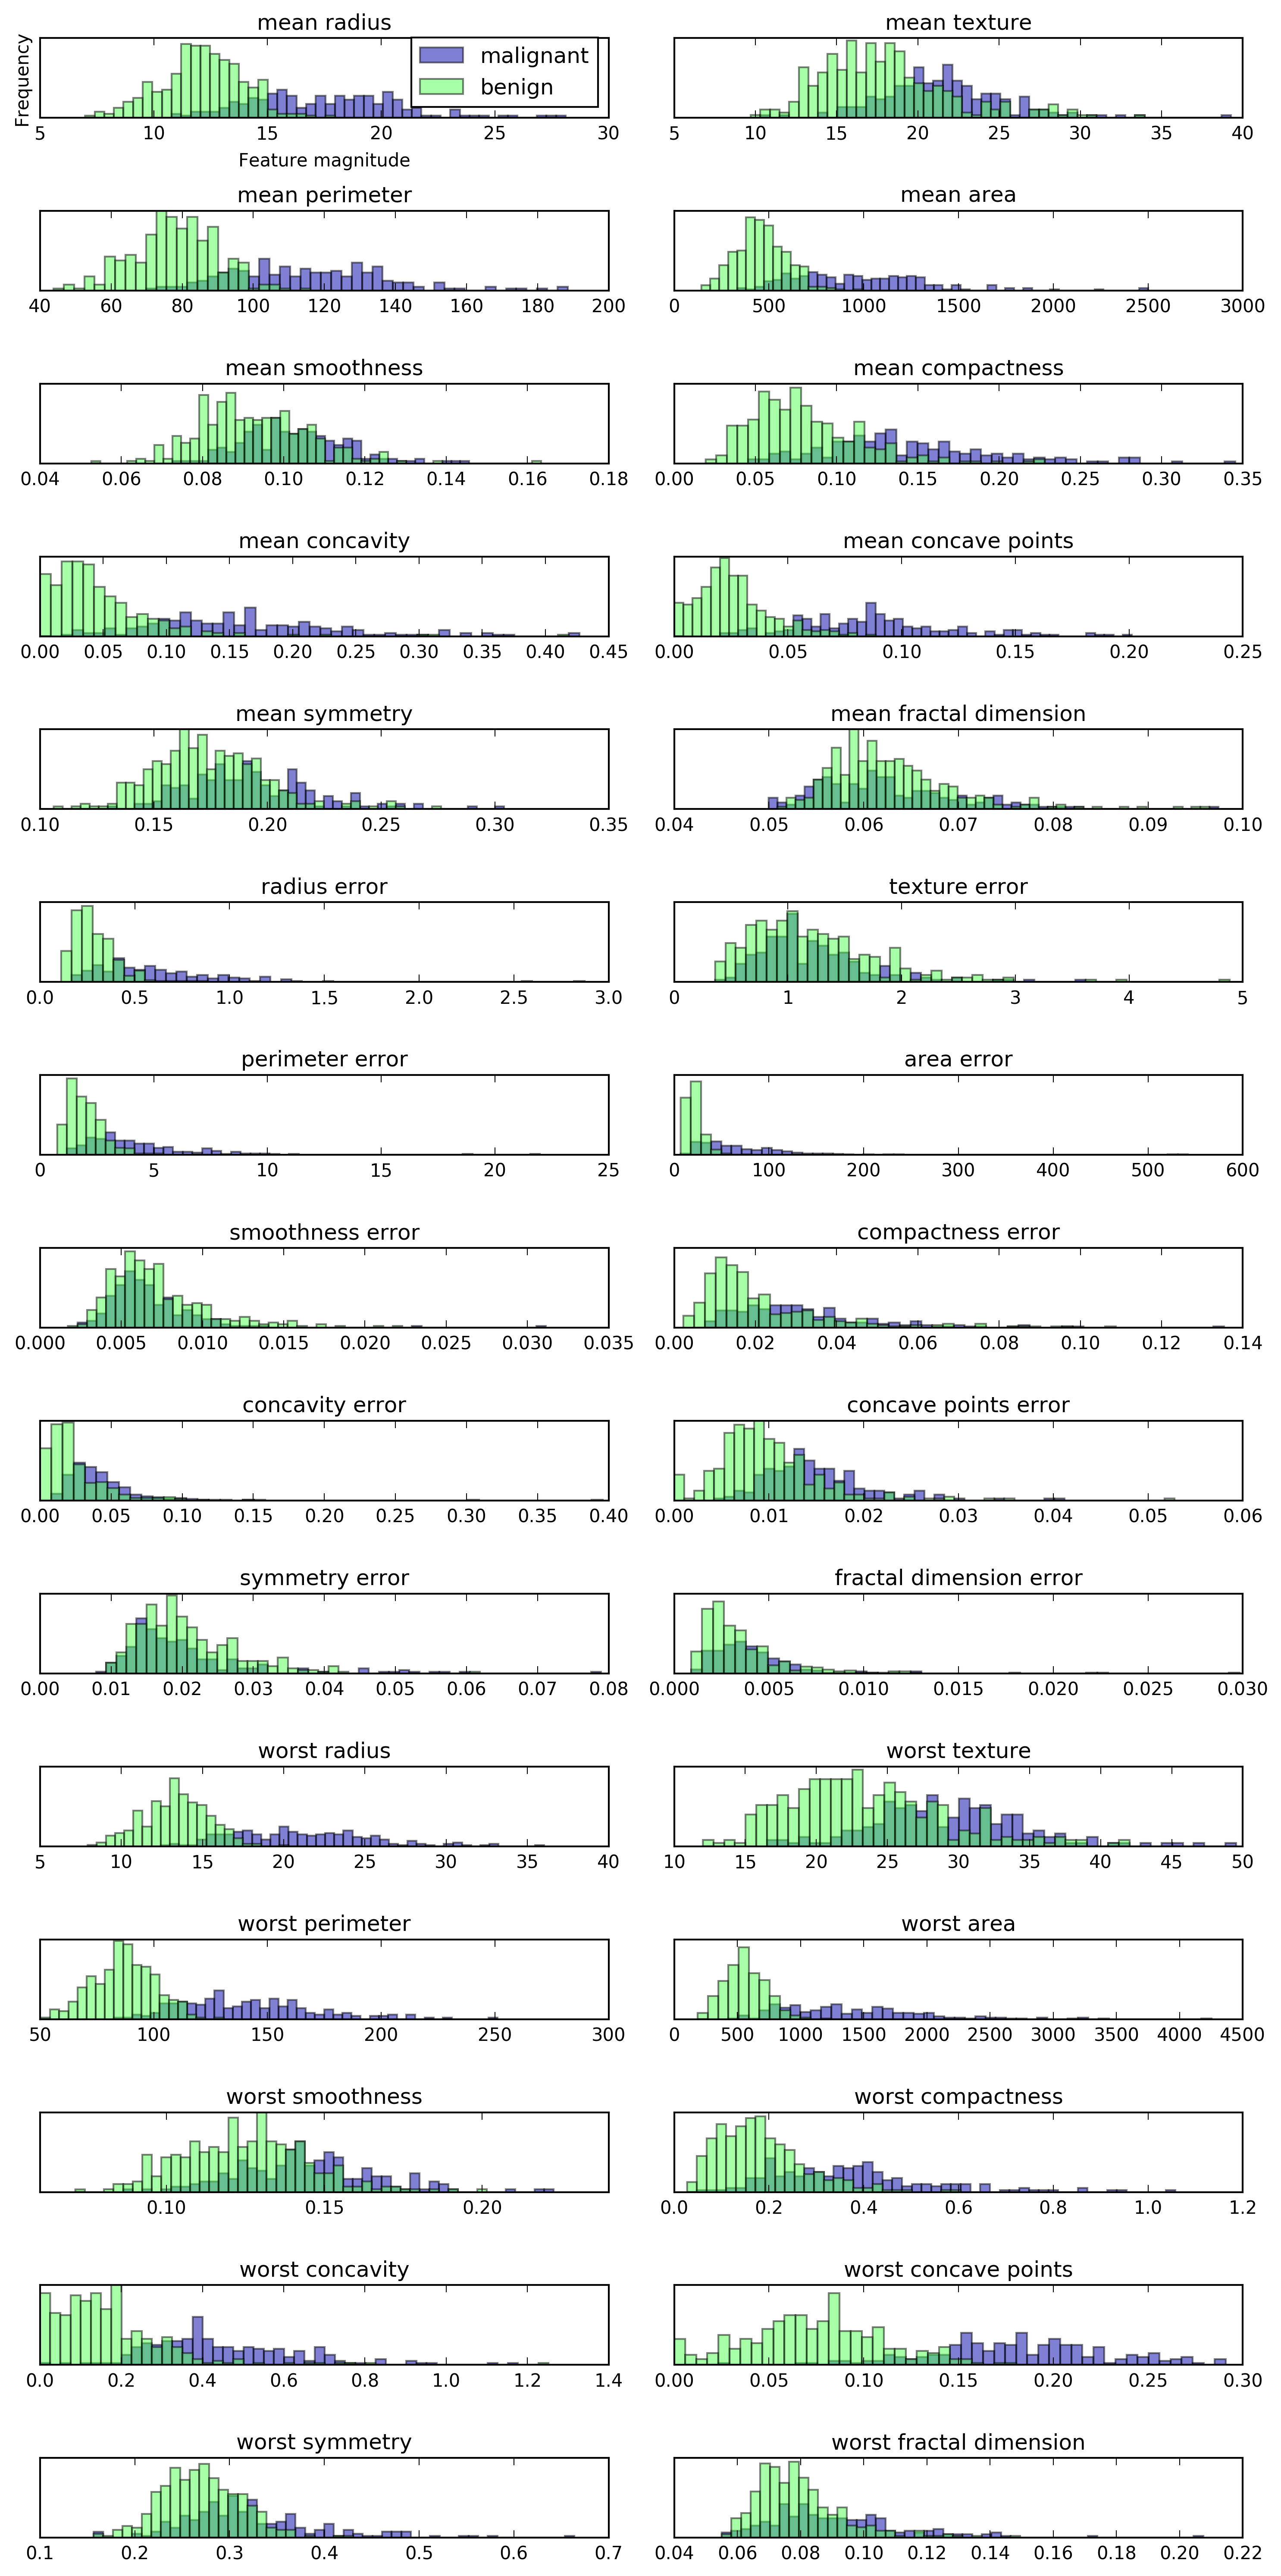

In [14]:
fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()

In [15]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

In [16]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=2)
# fit PCA model to beast cancer data
pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


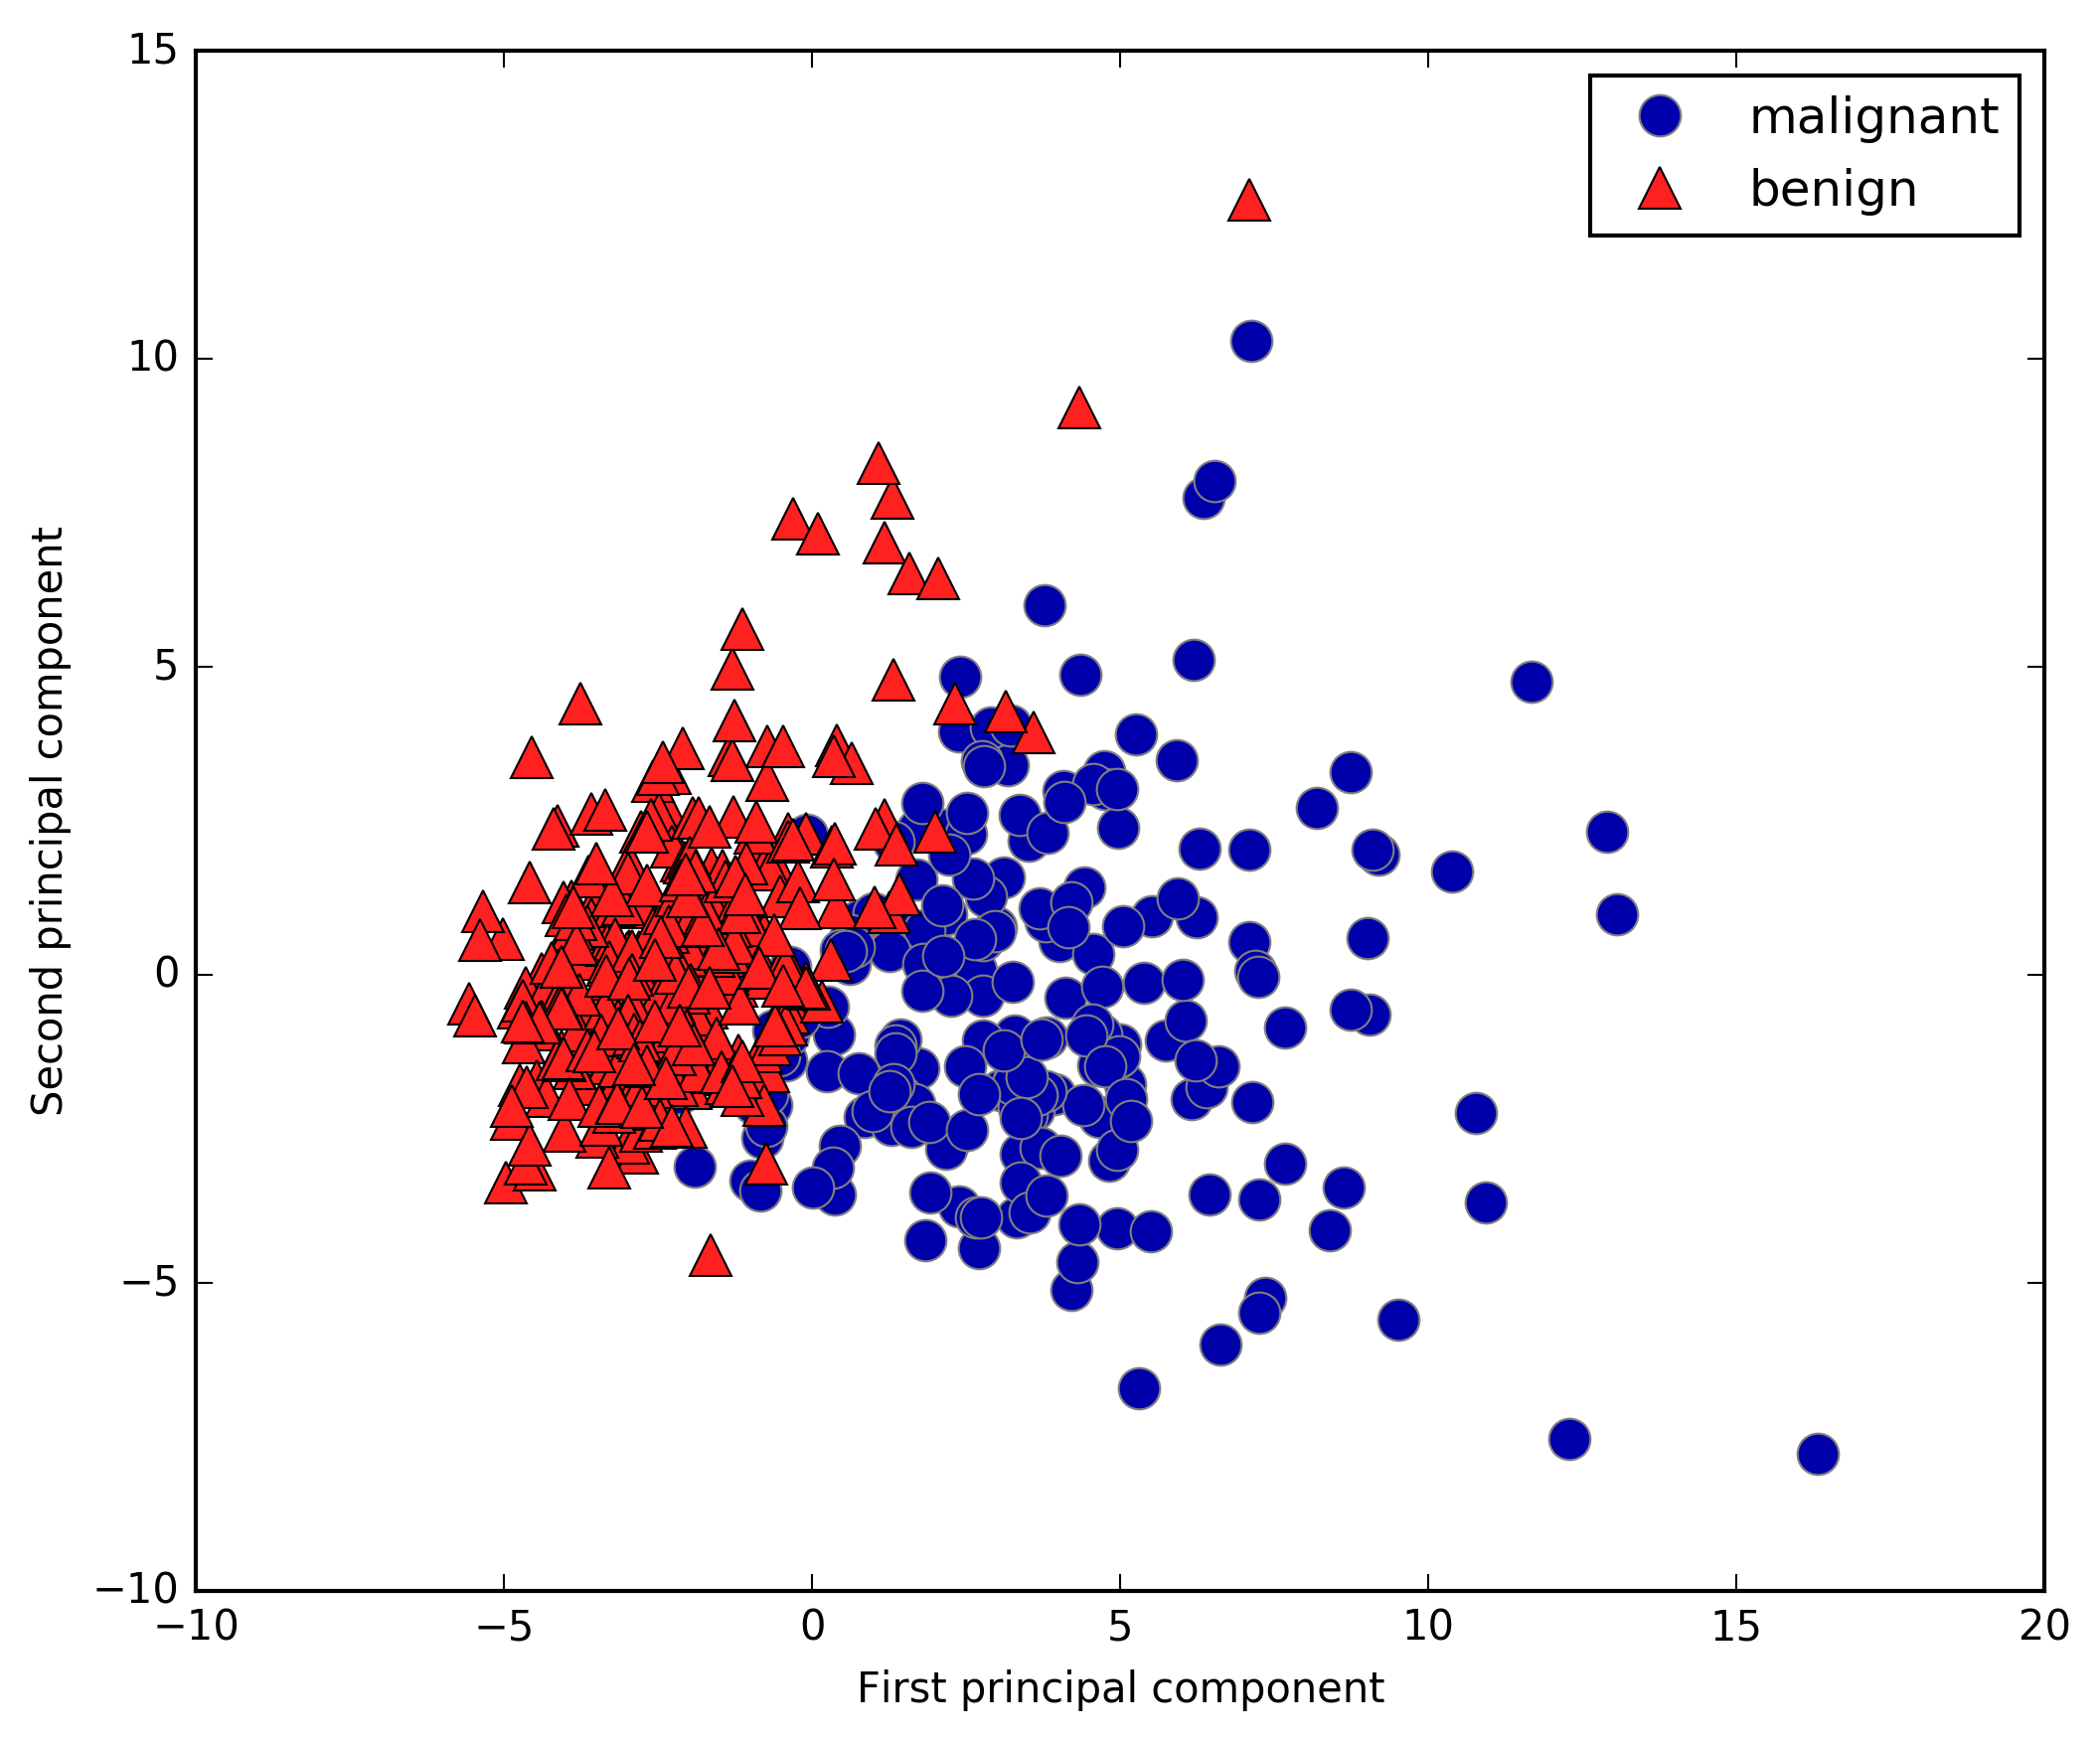

In [17]:
# plot fist vs second principal component, color by class
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

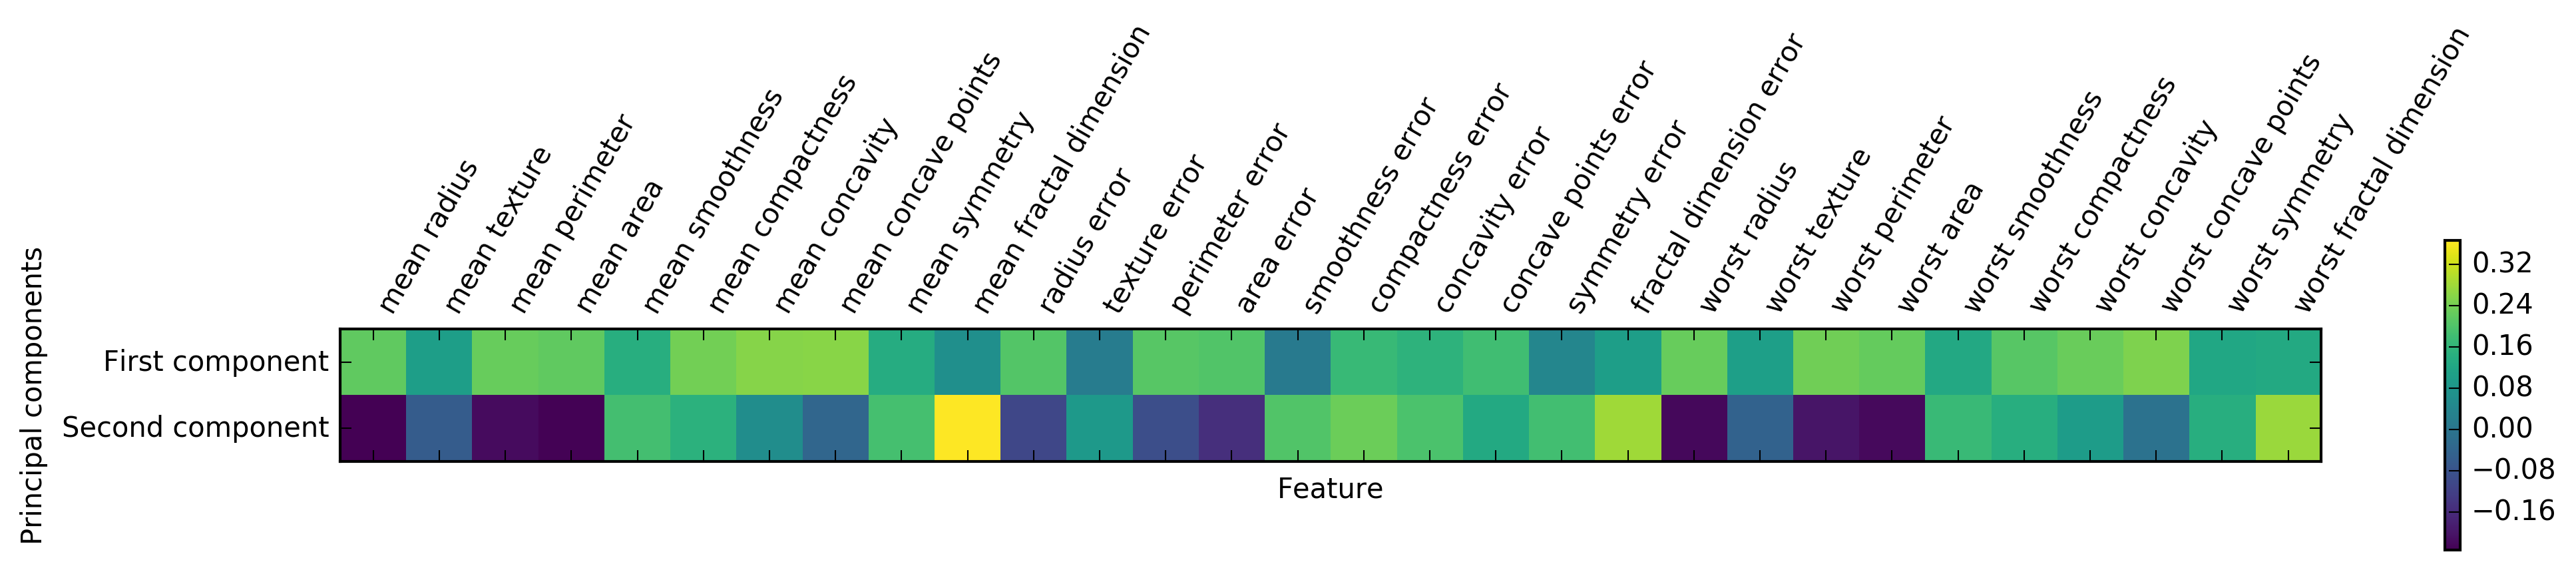

In [20]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
           cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")